# Investigation of AI-related Job Market

#### `Purpose`: to help job seekers to understand the growth of AI-related job market based on industries and location, prospective job roles, and important skills as well as knowledge to build.

#### Leads for EDA:  
1. What are the top 3 industries with most jobs in the dataset?
2. Which country has the most AI-related jobs?
3. How is the distribution of salary in the jobs based on remote friendly condition? Which job role has the highest average salary in remote/non-remote condition?
4. What are the most 3 important skills required for each job role?
5. How is the relationship between company size, AI adoption level, and automation risk with salary? 


In [1]:
# Import library
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt #for making other visualizations
import seaborn as sns #for making corr matrix
import scipy.stats as stats

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ai-powered-job-market-insights/ai_job_market_insights.csv


## DATA LOADING

In [3]:
# import dataset
main_data = pd.read_csv("/kaggle/input/ai-powered-job-market-insights/ai_job_market_insights.csv")

# show first 5 rows
main_data.head()

,Job_Title,Industry,Company_Size,Location,AI_Adoption_Level,Automation_Risk,Required_Skills,Salary_USD,Remote_Friendly,Job_Growth_Projection
0,Cybersecurity Analyst,Entertainment,Small,Dubai,Medium,High,UX/UI Design,111392.165243,Yes,Growth
1,Marketing Specialist,Technology,Large,Singapore,Medium,High,Marketing,93792.562466,No,Decline
2,AI Researcher,Technology,Large,Singapore,Medium,High,UX/UI Design,107170.263069,Yes,Growth
3,Sales Manager,Retail,Small,Berlin,Low,High,Project Management,93027.953758,No,Growth
4,Cybersecurity Analyst,Entertainment,Small,Tokyo,Low,Low,JavaScript,87752.922171,Yes,Decline


In [4]:
# check general information of the data
main_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Job_Title              500 non-null    object 
 1   Industry               500 non-null    object 
 2   Company_Size           500 non-null    object 
 3   Location               500 non-null    object 
 4   AI_Adoption_Level      500 non-null    object 
 5   Automation_Risk        500 non-null    object 
 6   Required_Skills        500 non-null    object 
 7   Salary_USD             500 non-null    float64
 8   Remote_Friendly        500 non-null    object 
 9   Job_Growth_Projection  500 non-null    object 
dtypes: float64(1), object(9)
memory usage: 39.2+ KB


#### Insights:
- There are 10 columns and 500 non-null values in this data.
- The data type is all strings except Salary_USD.
- Since there is no problem in the dataset, we can proceed to data visualization and statistics.

In [5]:
# format column names to all lower caps
main_data.columns = main_data.columns.str.lower()
main_data.columns

Index(['job_title', 'industry', 'company_size', 'location',
       'ai_adoption_level', 'automation_risk', 'required_skills', 'salary_usd',
       'remote_friendly', 'job_growth_projection'],
      dtype='object')

## DATA VISUALIZATION

### TOP 3 INDUSTRIES WITH MOST AI-RELATED JOBS

In [6]:
# make separate dataset
top_industries = main_data.groupby('industry').size().reset_index()
# rename the column
top_industries.rename(columns={0:'total_jobs'},inplace=True)
# sort based on total jobs
top_industries.sort_values(by='total_jobs',ascending=False,inplace=True)
top_industries

,industry,total_jobs
5,Manufacturing,58
0,Education,57
7,Technology,56
3,Finance,53
8,Telecommunications,53
1,Energy,49
2,Entertainment,47
6,Retail,46
4,Healthcare,42
9,Transportation,39


### Insights:
- The number of jobs for each industry in this dataset is pretty balanced. It's ranging from 39 to 58 jobs.
- We found our top three: Manufacturing, Education, and Technology.
- Let's convert the other industries into "Other" so it's not too much categories for visualizations.

In [7]:
# make new flag
# top three industries
top_three = ['Manufacturing','Education','Technology']
# initial category set as Others
top_industries['new_industry'] ='Others'

# keep original industry category for top three only
top_industries.loc[top_industries['industry'] == top_three[0],"new_industry"] = top_three[0]
top_industries.loc[top_industries['industry'] == top_three[1],"new_industry"] = top_three[1]
top_industries.loc[top_industries['industry'] == top_three[2],"new_industry"] = top_three[2]

top_industries

,industry,total_jobs,new_industry
5,Manufacturing,58,Manufacturing
0,Education,57,Education
7,Technology,56,Technology
3,Finance,53,Others
8,Telecommunications,53,Others
1,Energy,49,Others
2,Entertainment,47,Others
6,Retail,46,Others
4,Healthcare,42,Others
9,Transportation,39,Others


In [8]:
# drop previous column
top_industries.drop(columns='industry',axis = 1, inplace=True)

# regroup data
top_industries = top_industries.groupby('new_industry').total_jobs.sum().reset_index()

# show
top_industries.sort_values(by='total_jobs',ascending=False)

,new_industry,total_jobs
2,Others,329
1,Manufacturing,58
0,Education,57
3,Technology,56


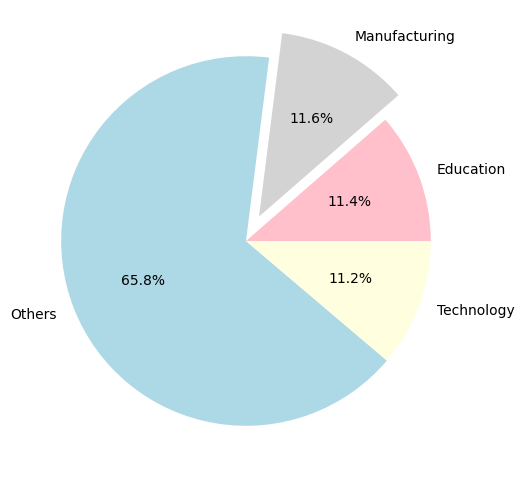

In [9]:
# create pie chart
plt.figure(figsize=(10,6))
# make an explosion for Manufacturing
myexplode = [0, 0.15, 0, 0]

# change color
colors = ['Pink', 'lightgrey', 'lightblue', 'lightyellow']
# autopct is for annotation with certain format
plt.pie(top_industries['total_jobs'],labels=top_industries['new_industry'],colors=colors, explode=myexplode, autopct='%1.1f%%')
plt.show()

## TOP 3 CITIES WITH MOST AI JOBS BASED ON AI-ADOPTION LEVELS

In [10]:
# make new dataset
most_ai_jobs_by_country = main_data.pivot_table(index = ['ai_adoption_level'], columns = ['location'], values = ['job_title'],aggfunc='count')
most_ai_jobs_by_country

job_title                                            \
location             Berlin Dubai London New York Paris San Francisco   
ai_adoption_level                                                       
High                      8    16     14       19    11            23   
Low                      23    11     13       14    22            16   
Medium                   17    24     19       16    13            23   

                                                  
location          Singapore Sydney Tokyo Toronto  
ai_adoption_level                                 
High                     16     15    13      12  
Low                      18     21    22      14  
Medium                   20     16    16      15

In [11]:
# just for learning
# Flatten the multi-index
# stacked_data = most_ai_jobs_by_country.stack(future_stack=True).reset_index()
# stacked_data

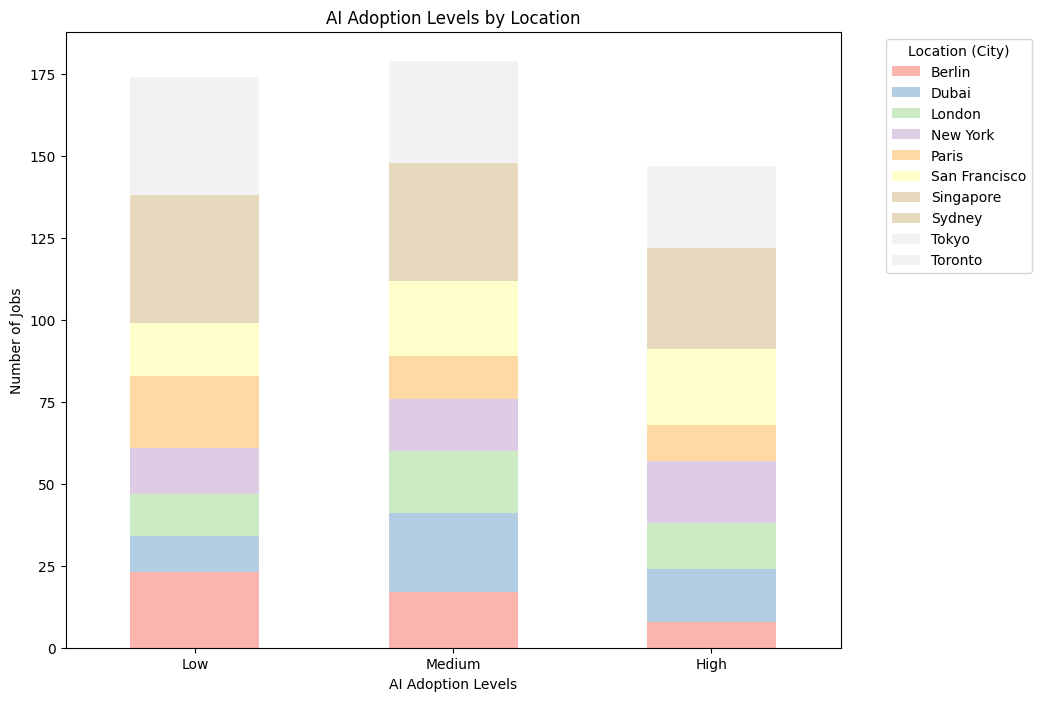

In [12]:
# rename job_title which is total_jobs
most_ai_jobs_by_country.columns = most_ai_jobs_by_country.columns.set_names('total_jobs', level=0)

# flatten the column names to extract only city names for the legend
most_ai_jobs_by_country.columns = most_ai_jobs_by_country.columns.get_level_values(1)

# order the index
most_ai_jobs_by_country= most_ai_jobs_by_country.reindex(['Low','Medium','High'],axis = 0)

# decide color palette
cmap = 'Pastel1'

# create stacked bar graph
ax= most_ai_jobs_by_country.plot(kind='bar',stacked=True, figsize=(10,8),cmap=cmap)

# customize legend location and names
ax.legend(title='Location (City)', bbox_to_anchor=(1.05, 1), loc='upper left')

# Add title, labels, and adjust ticks
plt.title('AI Adoption Levels by Location')
plt.xlabel('AI Adoption Levels')
plt.ylabel('Number of Jobs')
plt.xticks(rotation=0, ha='center')

# Display the plot
plt.show()

### Insights:
1. Top 3 cities with most jobs in high AI adoption level are San Francisco (23), New York (19), and Dubai and Singapore (16).
2. Top 3 cities with most jobs in medium AI adoption level are Dubai (24), San Francisco (23) and Singapore (18).
3. Top 3 cities with most jobs in low AI adoption level are Berlin (23), Paris and Tokyo (22) and Sydney (21).

Based on the analysis of job distribution across different AI adoption levels, San Francisco, Dubai, and Singapore demonstrate a higher concentration of AI-related jobs compared to other cities. This suggests a more integrated approach to AI in their job markets. However, further analysis considering other factors and potential biases is necessary to draw more definitive conclusions.

## SALARY DISTRIBUTION AND JOBS WITH MOST PAY

### How is the salary distribution based on remote friendly nature?

In [13]:
salary_dis = main_data.pivot_table(index='remote_friendly', values='salary_usd', aggfunc=['mean','median','min','max']).round()
salary_dis

,mean,median,min,max
,salary_usd,salary_usd,salary_usd,salary_usd
remote_friendly,,,,
No,90747.0,92250.0,33601.0,135779.0
Yes,91694.0,91567.0,31970.0,155210.0


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

Text(0.5, 1.0, 'Salary Distribution for Remote Friendly and Non-Remote Friendly AI-Jobs')

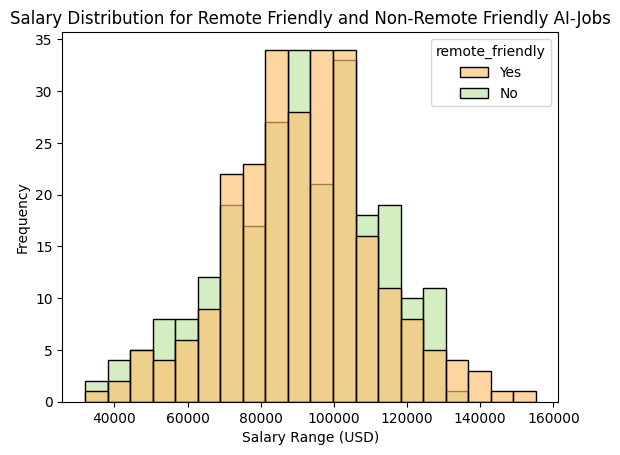

In [14]:
# salary distribution visualization based on remote_friendly environment
sns.histplot(data=main_data, x='salary_usd', hue = 'remote_friendly',alpha=0.65, palette='Spectral')
plt.xlabel('Salary Range (USD)')
plt.ylabel('Frequency')
plt.title("Salary Distribution for Remote Friendly and Non-Remote Friendly AI-Jobs")

### Insights:
1. Based on the histogram plot, salaries of jobs with remote friendly environment has wider range than non-remote friendly environment. For remote friendly environment, the range starts from around 40,000 USD to 150,000 USD, while non-remote starts from around 40,000 USD to 130,000 USD.
2. The histogram and mean results suggest that remote_friendly environment has slightly higher pay than non-remote friendly one. However, median-wise, non-remote is slightly higher than remote.  
 a. mean: 91,694 USD (remote) > 90,746 (non-remote)  
 b. median: 91,566 USD (remote) < 92,250 USD(non-remote)  
 c. min: 31,970 USD (remote) < 33,601 (non-remote)  
 b. max: 155,210 USD (remote) > 135,779 USD (non-remote)  
 
So in general, AI-jobs with remote friendly environment tends to have slightly higher pay by 1% based on average pays. In addition, it has the possibility to get pay as high as around 155k USD, more than non-remote opportunities. However, there are still other factors to consider for supporting this analysis such as considering experience, specific skills, company size, etc.

### Which Job Role has the Highest Average Salary?

In [15]:
# highest paying jobs
high_pay_jobs = main_data.pivot_table(index = 'job_title',columns='remote_friendly',values='salary_usd', aggfunc='mean').round()
high_pay_jobs

remote_friendly,No,Yes
job_title,,
AI Researcher,95448.0,95832.0
Cybersecurity Analyst,86096.0,91488.0
Data Scientist,93729.0,89630.0
HR Manager,86602.0,91044.0
Marketing Specialist,91348.0,90605.0
Operations Manager,97153.0,96653.0
Product Manager,84785.0,95961.0
Sales Manager,92543.0,93170.0
Software Engineer,82086.0,87886.0


In [16]:
# sort values
remote_job_title_salary= high_pay_jobs['Yes'].sort_values(ascending=False)
non_remote_job_title_salary= high_pay_jobs['No'].sort_values(ascending=False)

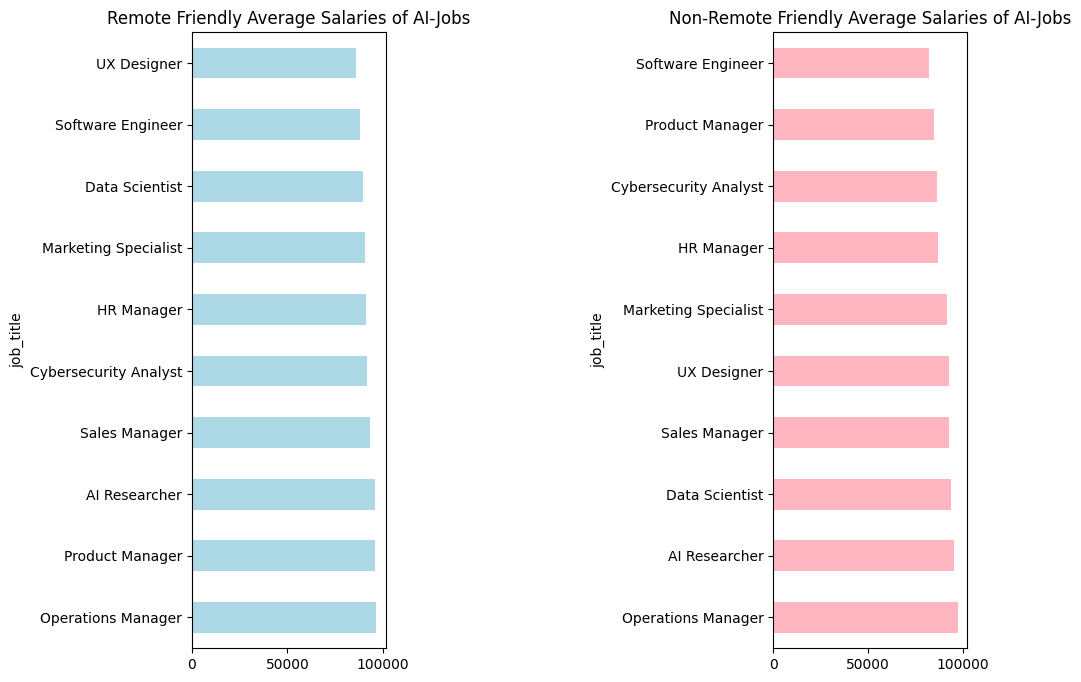

In [17]:
# plot on horizontal bar
fig, axes = plt.subplots(1,2,figsize=(10,8))

# adjust space between the plots
fig.subplots_adjust(wspace = 2)

# plot
remote_job_title_salary.plot.barh(ax=axes[0],color='lightblue',title='Remote Friendly Average Salaries of AI-Jobs')
non_remote_job_title_salary.plot.barh(ax=axes[1],color='lightpink', title='Non-Remote Friendly Average Salaries of AI-Jobs')
plt.show()

### Insights:
1. For both remote and non-remote friendly conditions, it's interesting that Operations Manager remains as the most average paying job which is almost 100,000 USD.  
2. Another interesting finding is that while in remote working, Product Manager is considered as the second highest paying job with average of around 95,000 USD, it's second lowest in non-remote working condition, about 84,000 USD.  
3. Next, UI/UX designers was paid the lowest in remote setting at 85,000 USD but, it's in the middle average salary range under non-remote setting which is around 92,000 USD.
4. Meanwhile, other jobs do not have that much salary difference than these three professions.

Therefore, this finding can be a recommendation that it's better to work remotely as Product Manager and non-remotely as UI/UX designers due to higher compensation. It's sensible for UI/UX designers to work non-remotely as their job nature requires more team collaboration and face-to-face interactions. Meanwhile, Product Manager and Operation Manager tasks can be versatilely handled in remote and non-remote conditions.

However, again, salary also depends on the background of the employee, relevant experience, company size, etc. 


## THE MOST IMPORTANT SKILL IN THE JOB ROLES

In [18]:
# make function to generate wordcloud for each job role
def wordcloud_generator(df):
    job_options = df.job_title.unique().tolist()
    for job_type in job_options:
    #     make filter
        job_filter = df['job_title'] == job_type
    #     store in a df and unify format
        df_job_title = df[job_filter]['required_skills'].str.lower()
    #     make list
        list_skills_per_job_title = df_job_title.tolist()
    #     connect by " "
        string_text = " ".join(list_skills_per_job_title)
    #    generate wordcloud
        word_cloud = WordCloud(width=400,height=200, background_color='white',colormap='viridis', contour_width=3,contour_color='black').generate(string_text)
    # Display the word cloud using Matplotlib
        plt.figure(figsize=(10, 5))

    # plt.imshow is to display data in image
    # bilinear to smooth and resize image
        plt.imshow(word_cloud, interpolation='bilinear')

    # to turn off label on axes and ticks
        plt.title(f"IMPORTANT SKILLS FOR {job_type.upper()}")
        plt.tick_params(axis='both', labelbottom=False, labelleft=False)
        plt.show()    

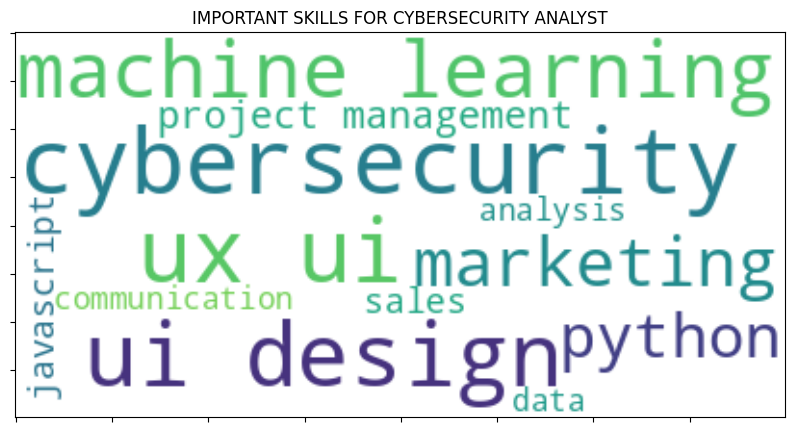

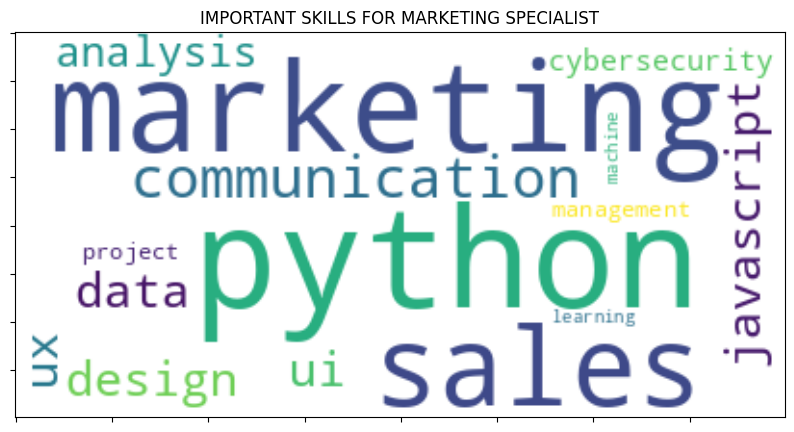

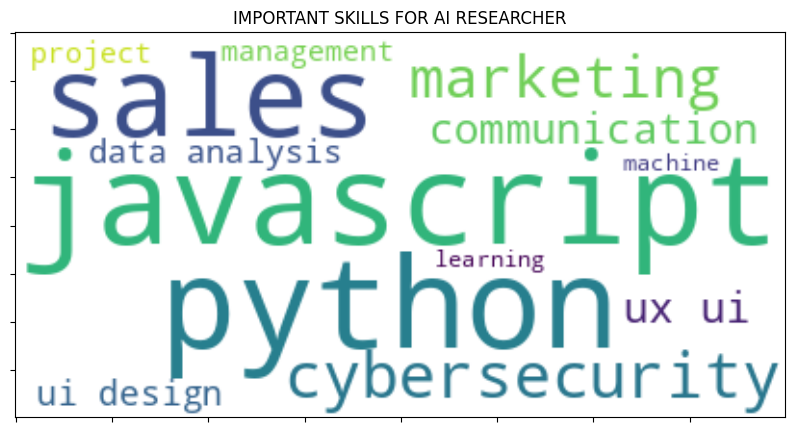

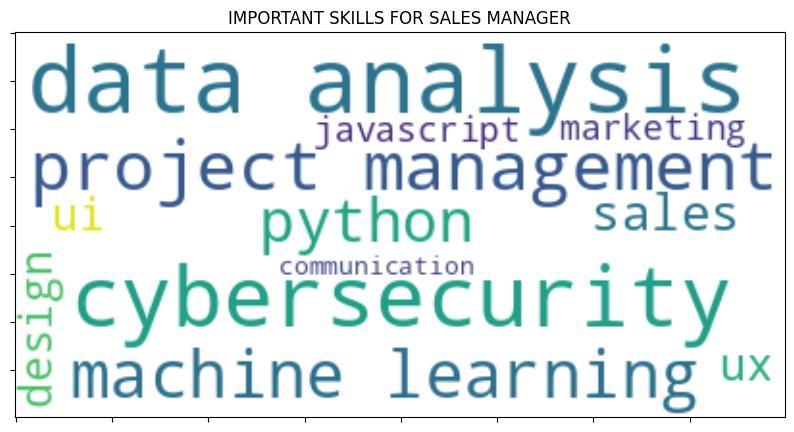

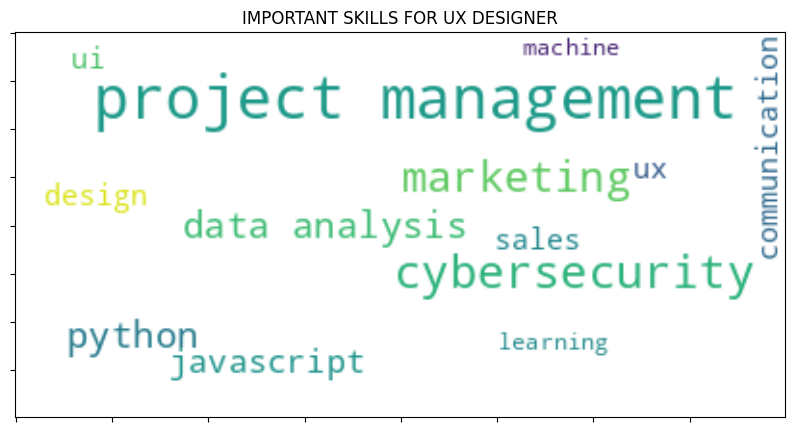

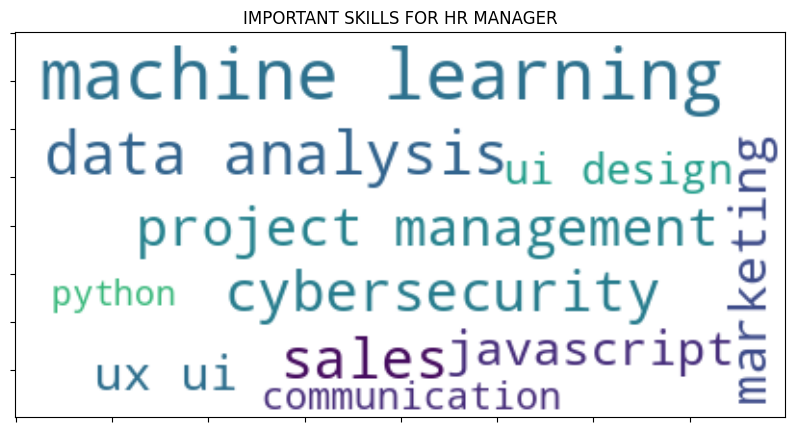

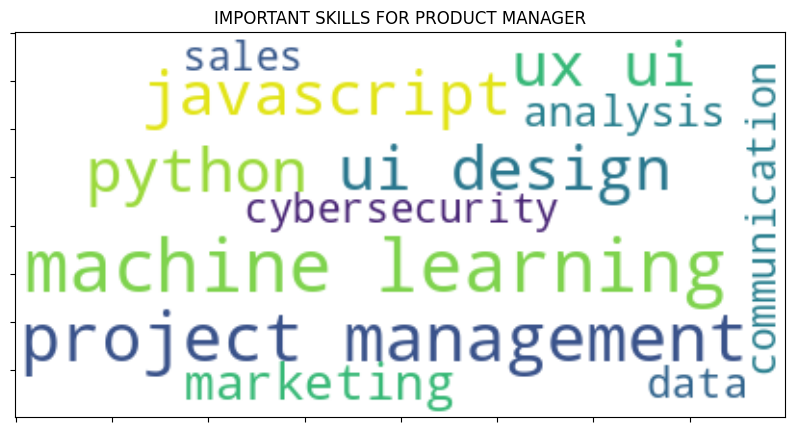

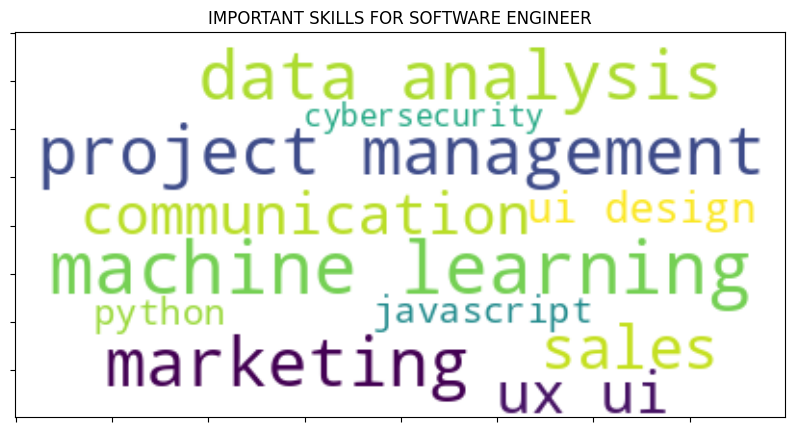

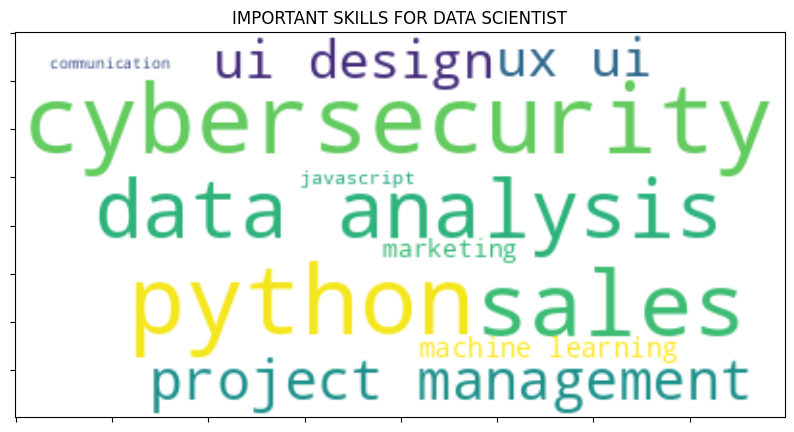

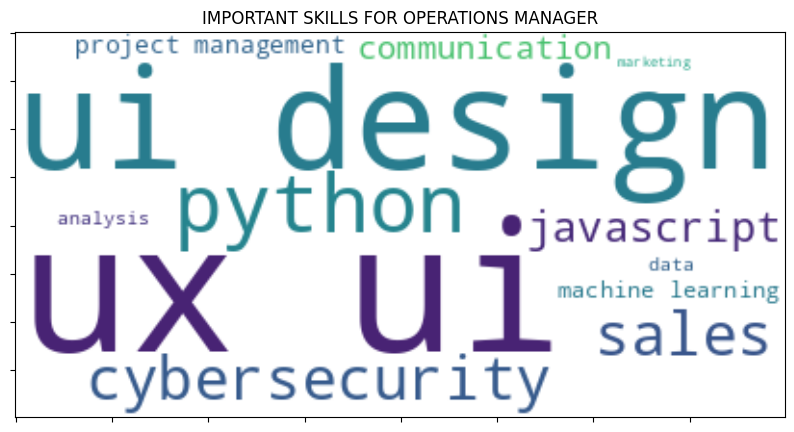

In [19]:
# show wordcloud result
wordcloud_generator(main_data)

### Insights:  
Take 3 top skills required for each job role:
1. **Cybersecurity Analyst**: cybersecurity, ux ui, and machine learning.  
2. **Marketing Specialist**: marketing, python, and sales.  
3. **AI Researcher**: python, javascript, sales.  
4. **Sales Manager**: cybersecurity, project management, data analysis.   
5. **UX Designer**: project management, cybersecurity, marketing.   
6. **HR Manager**: machine learning, data analysis, project management.  
7. **Product Manager**: project management, javascript, and machine learning.  
8. **Software Engineer**: machine learning, project management, data analysis.  
9. **Data Scientist**: python, cybersecurity, data analysis.  
10. **Operations Manager**: UI design, python, cybersecurity.  

Based on the wordcloud results,we can group the job roles in the following:  
a. **Technical jobs** --> emphasis on python, machine learning, javascript.  
  - Cybersecurity Analyst, AI Researcher, Software Engineer, Data Scientist.  
  
b. **Managerial jobs** --> enphasis on project management, data analysis, domain-heavy understanding (cybersecurity, marketing, sales, UI design).
   - Marketing Specialist, HR Manager, UX Designer, Product Manager, Operations Manager.  

This result can be a lead for people to focus their skills and knowledge to get aligned with their dream jobs.

## CORRELATION BETWEEN COMPANY SIZE, AI ADOPTION LEVEL, AND AUTOMATION RISK WITH SALARY

In [20]:
# check how many categories for company_size, ai_adoption_level, automation_risk
main_data.company_size.unique()

array(['Small', 'Large', 'Medium'], dtype=object)

In [21]:
# check how many categories for company_size, ai_adoption_level, automation_risk
main_data.ai_adoption_level.unique()

array(['Medium', 'Low', 'High'], dtype=object)

In [22]:
# check how many categories for company_size, ai_adoption_level, automation_risk
main_data.automation_risk.unique()

array(['High', 'Low', 'Medium'], dtype=object)

In [23]:
def order_data_changer(df,col_name):
    new_name = "new_" + col_name
    df[new_name] = 1
    df.loc[(df[col_name] == 'High')| (df[col_name] == 'Large'),new_name] = 3
    df.loc[df[col_name] == 'Medium',new_name] = 2
    return df

In [24]:
# for automation_risk
copy_main_data = main_data.copy()
copy_main_data = order_data_changer(copy_main_data,'automation_risk')
copy_main_data = order_data_changer(copy_main_data,'ai_adoption_level')
copy_main_data = order_data_changer(copy_main_data,'company_size')
copy_main_data.head()

,job_title,industry,company_size,location,ai_adoption_level,automation_risk,required_skills,salary_usd,remote_friendly,job_growth_projection,new_automation_risk,new_ai_adoption_level,new_company_size
0,Cybersecurity Analyst,Entertainment,Small,Dubai,Medium,High,UX/UI Design,111392.165243,Yes,Growth,3,2,1
1,Marketing Specialist,Technology,Large,Singapore,Medium,High,Marketing,93792.562466,No,Decline,3,2,3
2,AI Researcher,Technology,Large,Singapore,Medium,High,UX/UI Design,107170.263069,Yes,Growth,3,2,3
3,Sales Manager,Retail,Small,Berlin,Low,High,Project Management,93027.953758,No,Growth,3,1,1
4,Cybersecurity Analyst,Entertainment,Small,Tokyo,Low,Low,JavaScript,87752.922171,Yes,Decline,1,1,1


In [25]:
# get specific columns for correlation study
df_correlation = copy_main_data[['new_automation_risk','new_ai_adoption_level','new_company_size','salary_usd']]
# make correlation matrix
corr_matrix = df_correlation.corr(method='spearman')

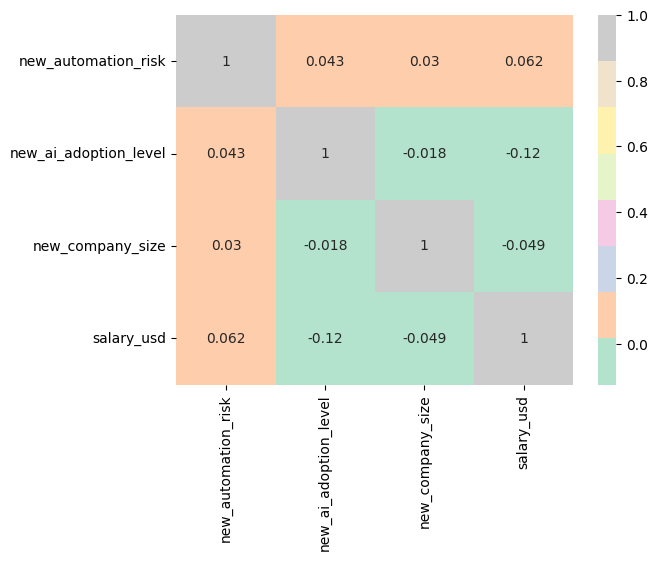

In [26]:
# generate heatmap
sns.heatmap(corr_matrix, annot=True, cmap='Pastel2')
plt.show()

### Insights:
1. The variables are weakly correlated with one another due to low Spearman Rank coefficients.   
2. The variables new_ai_adoption_level and salary_usd have the strongest correlation coefficient at -0.12.  
3. Meanwhile, the weakest correlation is between new_company_size and salary_usd at -0.049.

However, we need to check whether these relationships are statistically significant or not.

In [27]:
# check statistical significances with hypothetical testing
def spearman_test(df,col_names):
    for col in col_names:
        rho, p = stats.spearmanr(df[col],df['salary_usd'])
        print(f"Spearman Rank Stats. Test for {col.upper()} and SALARY")
        print(f'rank correlation value: {rho.round(2)}')
        if p <= 0.05:
            print(f"The correlation is statistically significant since p-value is {p.round(2)}, less than 0.05\n")
        else:
            print(f"The correlation is not statistically significant since p-value is {p.round(2)}, more than 0.05\n")


In [28]:
# make list of column names
column_names = ['new_automation_risk', 'new_ai_adoption_level','new_company_size']
spearman_test(df_correlation,column_names)

Spearman Rank Stats. Test for NEW_AUTOMATION_RISK and SALARY
rank correlation value: 0.06
The correlation is not statistically significant since p-value is 0.17, more than 0.05

Spearman Rank Stats. Test for NEW_AI_ADOPTION_LEVEL and SALARY
rank correlation value: -0.12
The correlation is statistically significant since p-value is 0.01, less than 0.05

Spearman Rank Stats. Test for NEW_COMPANY_SIZE and SALARY
rank correlation value: -0.05
The correlation is not statistically significant since p-value is 0.27, more than 0.05



### Insights:

 Based on the Spearman Rank Correlation Test, there is a statistically significant correlation between ai_adoption_level and salary, with a p-value of 0.01, which is less than the 0.05 significance level.   

 This result suggests that as the AI adoption level increases, salaries tend to decrease. This trend may be reasonable because managerial roles (e.g., Operations Manager, Product Manager, Sales Manager), which typically command higher salaries, are often responsible for overseeing AI-related specialists in technical roles (e.g., Cybersecurity Analyst, Software Engineer, Data Scientist).   

 Since managerial positions require broader, non-technical skills and strategic oversight, they are generally compensated at higher levels compared to technical roles, where salaries might be more influenced by the increasing automation and AI adoption.

## CONCLUSION AND REMARKS

### I. CONCLUSION
In conclusion, this study found out that there is not much difference of job opportunities among the industries (at most 10%) but, the top 3 industries assimilated with AI are Manufacturing, Education, and Technology. Next, the cities with highest AI adoption level in the job market includes San Fransisco, Dubai, and Singapore based due to most job opportunities in middle and high AI adoption levels.  

Talking about salary distribution, remote friendly environment has greater range than non-remote friendly environment with slightly higher mean salaries. This result indicates that remote job opportunities have more lucrative compensation.If we extend the analysis further to the job roles with their respective average salaries in remote and non-remote conditions,  

 a. Operations Manager gets the highest pay, implying the nature of job is versatile in both situations.   
 b. Following that, Product Manager stands as the second most-paying job in remote but contrastly the second lowest paying job in non-remote condition. Therefore, it's better to seek remote position for this role.  
 c. Next is UI/UX designer which has the lowest pay in remote but not as bad in non-remote condition. This can be explained by the nature of the role demanding more frequent face-to-face interactions and collaborations for good job output.  

Through wordcloud results,we can check the top three skills and knowledge required to the job roles which can be a guideline for people to reach their dream jobs. In addition, this study classified the job roles into two groups for easier understanding:  
a. **Technical jobs** --> emphasis on python, machine learning, javascript.  
  - Cybersecurity Analyst, AI Researcher, Software Engineer, Data Scientist.  
  
b. **Managerial jobs** --> enphasis on project management, data analysis, domain-heavy understanding (cybersecurity, marketing, sales, UI design).
   - Marketing Specialist, HR Manager, UX Designer, Product Manager, Operations Manager.    

Finally, the Spearman Rank correlation matrix and tests showed that the level of AI adoption level and salary have a weak negative correlation. It can be inferred that higher AI adoption level translates to lower compensation which is possible knowing that existence of AI can replace certain technical roles through automation and non-technical skills in managerial roles are valuable for the business to run.

### II. REMARKS

This study has a limited scope for understanding the AI-related job market due to lack of data. For example, the required experience level, year when the job is posted, depth of job role skills can give clearer image about the market.   
On the other hand, these findings can still guide job seekers to search potential job locations, possibly better with remote working and invest in correct skills and knowledge for their desired roles.
